Project Introduction:
My project will be using Amazon Video Game Reviews and using deep learning models to predict customer opinions from natural language text. This data was gathered from https://nijianmo.github.io/amazon/index.html which is a free and open resource that has amazon reviews for many different categories, the one I chose is for video games. I am going to use binary sentiment classification on these reviews. Each review in the data has a user review that is made of natural text and a star rating (1-5 stars) I will be making this a supervised learning task and for the classification it will be 1-2 stars as negative and 4-5 as positive sentiment 3 stars will be considered neutral and removed in this case. 

Our goal is to infer natural language patterns by video game customers on amazon. I will compare different models like by using TF-IDF vectorization on Linear Regression, linear SVC, and MLP (NN) based model to help find what model architechture fits best with this project. 

Gather data, determine the method of data collection and provenance of the data 

This data was provided by https://nijianmo.github.io/amazon/index.html for free on their website as long as we provide citation to their study:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

But we are not using their study in anyway but just some of the data they provided to perform our own project. 

This data has 497,577 reviews in it with this structure given to us as an example on their website:
{
"image": ["https://images-na.ssl-images-amazon.com/images/I/71eG75FTJJL._SY88.jpg"], 
"overall": 5.0, 
"vote": "2", 
"verified": True, 
"reviewTime": "01 1, 2018", 
"reviewerID": "AUI6WTTT0QZYS", 
"asin": "5120053084", 
"style": {
	"Size:": "Large", 
	"Color:": "Charcoal"
	}, 
"reviewerName": "Abbey", 
"reviewText": "I now have 4 of the 5 available colors of this shirt... ", 
"summary": "Comfy, flattering, discreet--highly recommended!", 
"unixReviewTime": 1514764800
}

In [47]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





Load in our Data 

In [3]:
rows = []
with open("Video_Games_5.json", "r") as f:
    for line in f:
        rows.append(json.loads(line))

df = pd.DataFrame(rows)

print("Shape:", df.shape)
df.head()

Shape: (497577, 12)


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
# df.info()

# CHeck the data to see were the NaNs are 
print(df.isna().sum())

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          76
reviewText           158
summary              109
unixReviewTime         0
vote              389784
style             208340
image             493943
dtype: int64


Filter down the columns to keep

In [5]:
cols_to_keep = [
    "overall", 
    "reviewText",  
    "summary", 
    "verified", 
    "reviewTime",      
    "unixReviewTime",  
    "asin",   
    "reviewerID"
]

df = df[cols_to_keep].copy()
df.shape
df.head()

,overall,reviewText,summary,verified,reviewTime,unixReviewTime,asin,reviewerID
0,5.0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,True,"10 17, 2015",1445040000,0700026657,A1HP7NVNPFMA4N
1,4.0,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",False,"07 27, 2015",1437955200,0700026657,A1JGAP0185YJI6
2,3.0,ok game.,Three Stars,True,"02 23, 2015",1424649600,0700026657,A1YJWEXHQBWK2B
3,2.0,"found the game a bit too complicated, not what...",Two Stars,True,"02 20, 2015",1424390400,0700026657,A2204E1TH211HT
4,5.0,"great game, I love it and have played it since...",love this game,True,"12 25, 2014",1419465600,0700026657,A2RF5B5H74JLPE


Remove NaNs 

In [6]:
# Remove NaN from reviewText and overall
df = df[~df["reviewText"].isna()]
df = df[~df["overall"].isna()]
# Get rid of reviewText that are empty and whitespace
df["reviewText"] = df["reviewText"].astype(str)
df = df[df["reviewText"].str.strip().str.len() > 0]

df.shape

(497419, 8)

Find the distribution of stars, this might tell us about how reviews are being done.

count    497419.000000
mean          4.220297
std           1.185491
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64


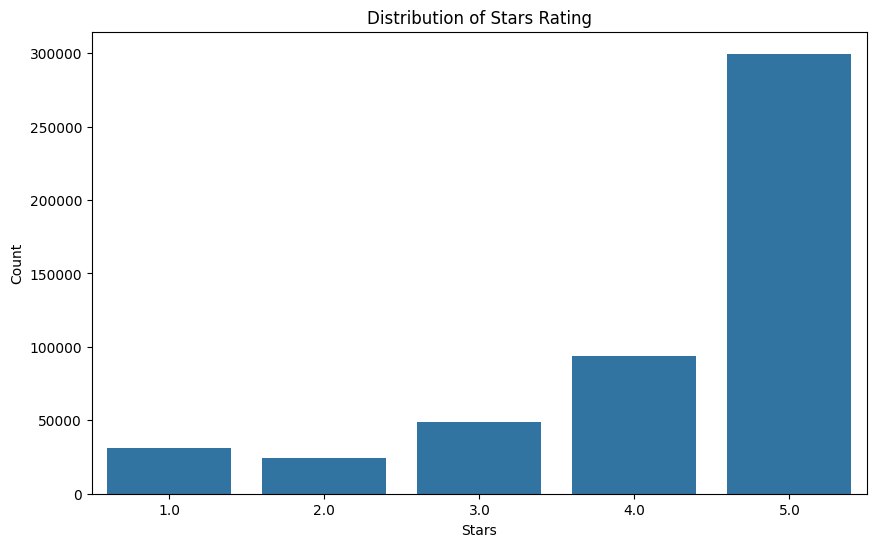

In [7]:
# see the distribution of stars 
print(df["overall"].describe())
# plot the distriubtion
plt.figure(figsize=(10,6))
sns.countplot(x="overall", data=df, order=sorted(df["overall"].unique()))
plt.title("Distribution of Stars Rating")
plt.xlabel("Stars")
plt.ylabel("Count")
plt.show()



In order to make our model binary we are change 1 and 2 to 0(negative) and 4 and 5 to 1 (positive). 3 will be left as they will be neutral.

sentiment
1    393267
0     55012
Name: count, dtype: int64


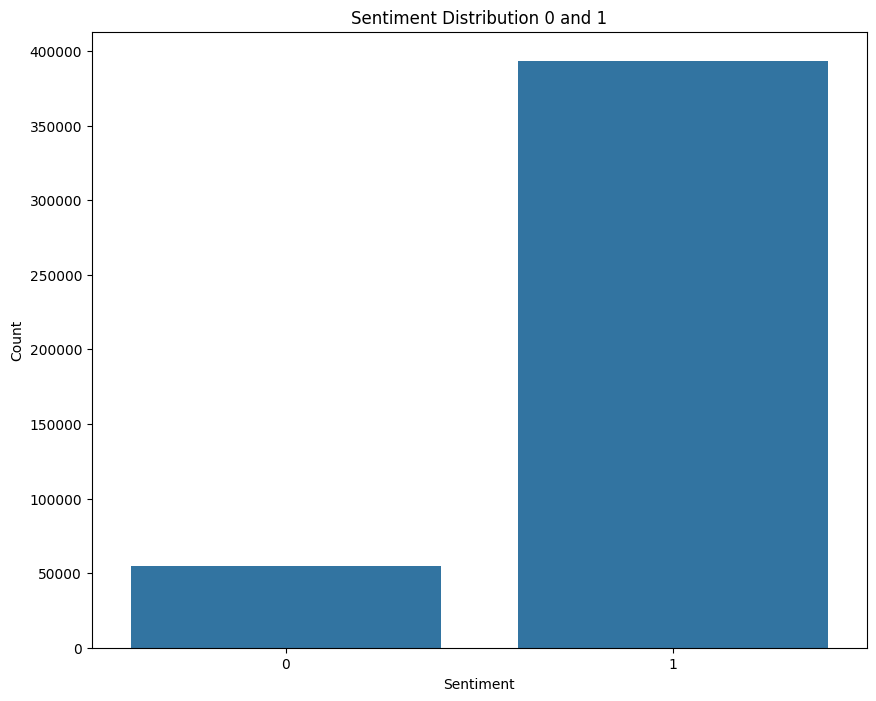

In [8]:
df_binary = df[df["overall"].isin([1.0, 2.0, 4.0, 5.0])].copy()

# 4 and 5 are going to be binary 1 (positive) and 1 and 2 are going to be binary 0 (negative)
# 3 stars will be removed
star_map = {1.0: 0, 2.0: 0, 4.0: 1, 5.0: 1}
df_binary["sentiment"] = df_binary["overall"].map(star_map)

df_binary.shape
# get the counts of positive and negative in sentiment
print(df_binary["sentiment"].value_counts())

# plot the distirubtion of 0 and 1
plt.figure(figsize=(10,8))
sns.countplot(x="sentiment", data=df_binary)
plt.title("Sentiment Distribution 0 and 1")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Looking at the counts for words and characters in the reviews.

           len_chars      len_words
count  448279.000000  448279.000000
mean      631.737282     115.660843
std      1222.273071     219.060765
min         1.000000       1.000000
25%        51.000000      10.000000
50%       193.000000      37.000000
75%       655.000000     122.000000
max     32721.000000    5928.000000


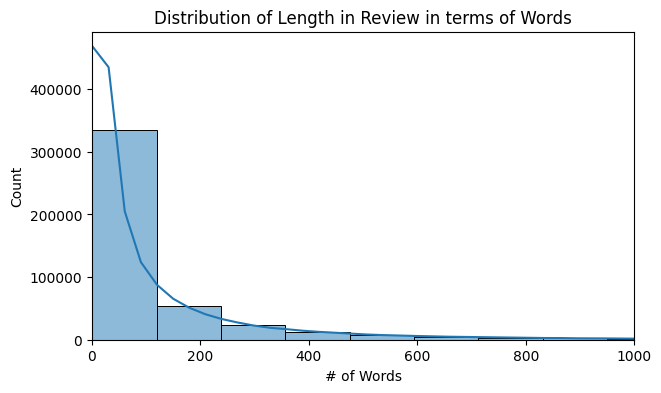

In [9]:
# get the counts for words and characters
df_binary["len_chars"] = df_binary["reviewText"].str.len()
df_binary["len_words"] = df_binary["reviewText"].str.split().str.len()

print(df_binary[["len_chars", "len_words"]].describe())

plt.figure(figsize=(7,4))
sns.histplot(df_binary["len_words"], bins=50, kde=True)
plt.title("Distribution of Length in Review in terms of Words")
plt.xlabel("# of Words")
plt.ylabel("Count")
plt.xlim(0, 1000)  
plt.show()

There seems to be a lot of short reviews, and they taper off a lot as we get to the 100 word count range.

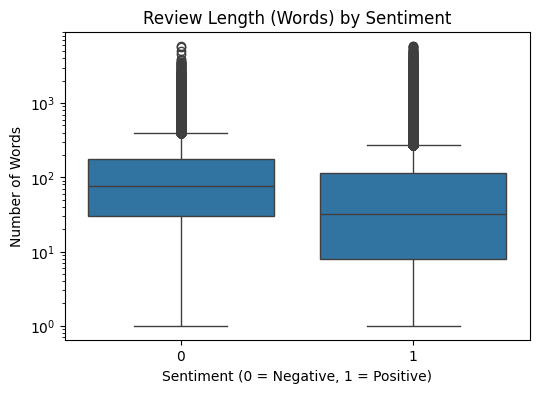

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x="sentiment", y="len_words", data=df_binary)
plt.title("Review Length (Words) by Sentiment")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Number of Words")
# log scale becaught there are so many extremes 
plt.yscale("log")
plt.show()

Here we see that negatie reviews tend to have longer word length in their reviews, while positive reviews have a bigger range but on average are shorter. 

Heat mape of features to see what correlates with each other in our data

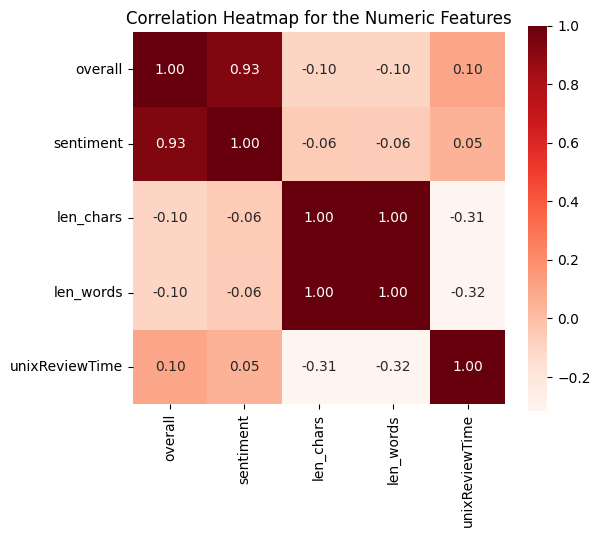

In [11]:
num_cols = ["overall", "sentiment", "len_chars", "len_words", "unixReviewTime"]
corr = df_binary[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Reds", square=True)
plt.title("Correlation Heatmap for the Numeric Features")
plt.show()

EDA: 
The amazon video game review data had a lot of data that varied from texts, numbers, and other field for each review. For preparing this data for my machine learning models I had to analyze and clean the data up.

I initially cleaned up columns that were not going to be used in my models and also handled missing and NaN values in the data. This provided me with a cleaned up set of data to use. 

Then I looked at the distribution of star ratings for reviews and saw there was a lot more reviews that were higher rated than lower rated. This was somewhat understood as people tend to leave more positive reviews than negative. I also created a binary sentiment dataset where 1-2 stars become a binary 0 for negative reviews and 4-5 stars become binary 1 for positive reviews, and 3 was left out due it being neutral. 

I also plotted and looked at length of reviews in terms of characters and words. Most reviews tended to be around 10 to 100 words while there were outliers that were much longer. I also made a box plot to compare negative and positive reivews length and saw that negative reviews on average were longer than positive reviews, this was done in log scale as the outliers were much longer than normal reviews. Through this I understood that length might be an indicator sentitment in our model when we do predictions.

I made a heatmap showing the correlation of features, however this did not provide that much meaningful results and it mainly told me that the text itself is going to be a stronger indicator for predictions than the features we have. 

Below I am going to do the last step of my EDA which is transforming, as machine learning models don't work with raw text we are going to make TF-IDF vectors for the words, which normalizes frequency of terms and reduces the impact of words that are used more often. 

Using a smaller sample size due to computer restraints

In [24]:

df = df_binary.copy()

df["text"] = df["reviewText"].astype(str)

max_samples = 60000

if len(df) > max_samples:
    df_small = df.sample(n=max_samples, random_state=42)
else:
    df_small = df.copy()

print("Using this many reviews:", len(df_small))

texts = df_small["text"].values
labels = df_small["sentiment"].astype(int).values


Using this many reviews: 60000


Here we need to split our training, testing, and validation

In [25]:

# we need to separate our data into 70% train 15% test and 15% validation
# first we split the test by 15%
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.15, random_state=42, stratify=labels
)
# validation needs to be 15% of the remaining 85% so we get 17.65% of the rest of the data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 41998
Val size: 9002
Test size: 9000


Here we are transforming our data using TfidVectorizer to make it compatible with machine learning models

In [26]:
tfidf = TfidfVectorizer(
    max_features=60000,
    ngram_range=(1, 2), 
    min_df=5 
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape


((41998, 60000), (9002, 60000), (9000, 60000))

Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

We are going to use three supervised machine learning models logistic regression, support vector machine, and multilayer perceptron. We are going to classify our reviews to be positive or negative sentiment with the models. ALl will use our TF-IDF vectorized text as inputs.


Logistic Regression is our baseline because fast and has high performance in TF-IDF spaces. It uses linear decision boundary that could be good for sentiment binary ratings

In [50]:
log_reg = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log = log_reg.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_log, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))



/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


              precision    recall  f1-score   support

           0     0.9132    0.4620    0.6136      1093
           1     0.9304    0.9939    0.9611      7907

    accuracy                         0.9293      9000
   macro avg     0.9218    0.7280    0.7874      9000
weighted avg     0.9283    0.9293    0.9189      9000

Confusion Matrix:
[[ 505  588]
 [  48 7859]]


Logistic Regression performed better than i expected, as it had a high accuarcy score, but this does not mean it did that well as for the predicting 0 or negative reviews it performed very poorly. I believe this is because the it is a linear model and because our data is so skewed to the 1 or positive reviews this model suffers greatly from that. 

In [30]:

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size="auto",
    learning_rate="adaptive",
    max_iter=10, 
    random_state=42,
    verbose=True,
    warm_start=True 
)

best_val_f1 = -1.0
best_mlp = None


for epoch in range(1, 6):
    print(f"\n Epoch:  {epoch}")
    mlp.fit(X_train_tfidf, y_train)

    # Evaluate on validation set
    y_val_pred = mlp.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, y_val_pred)

    print("Validation F1: ", val_f1)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_mlp = MLPClassifier(**mlp.get_params())
        best_mlp.fit(X_train_tfidf, y_train)

# Evaluate best model on test set
y_pred_mlp = best_mlp.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_mlp, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))



 Epoch:  1


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.28043140
Iteration 2, loss = 0.07119936
Iteration 3, loss = 0.02153073
Iteration 4, loss = 0.01122020
Iteration 5, loss = 0.00858854
Iteration 6, loss = 0.00750695
Iteration 7, loss = 0.00675505
Iteration 8, loss = 0.00615625
Iteration 9, loss = 0.00603720
Iteration 10, loss = 0.00582116
Validation F1:  0.9657465495608532


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.28043140
Iteration 2, loss = 0.07119936
Iteration 3, loss = 0.02153073
Iteration 4, loss = 0.01122020
Iteration 5, loss = 0.00858854
Iteration 6, loss = 0.00750695
Iteration 7, loss = 0.00675505
Iteration 8, loss = 0.00615625
Iteration 9, loss = 0.00603720
Iteration 10, loss = 0.00582116

 Epoch:  2


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.01922987
Iteration 2, loss = 0.01165516
Iteration 3, loss = 0.00651937
Iteration 4, loss = 0.00571882
Iteration 5, loss = 0.00548715
Iteration 6, loss = 0.00537087
Iteration 7, loss = 0.00525521
Iteration 8, loss = 0.00520963
Iteration 9, loss = 0.00513064
Iteration 10, loss = 0.00512505
Validation F1:  0.9626738843079247

 Epoch:  3


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.01863857
Iteration 2, loss = 0.01265650
Iteration 3, loss = 0.00637652
Iteration 4, loss = 0.00535297
Iteration 5, loss = 0.00514779
Iteration 6, loss = 0.00507720
Iteration 7, loss = 0.00501586
Iteration 8, loss = 0.00498259
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Validation F1:  0.9614706623016872

 Epoch:  4


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.02032708
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Validation F1:  0.9608397762272928

 Epoch:  5


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.01790585
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Validation F1:  0.9602419507277424
              precision    recall  f1-score   support

           0     0.7933    0.7374    0.7643      1093
           1     0.9641    0.9734    0.9687      7907

    accuracy                         0.9448      9000
   macro avg     0.8787    0.8554    0.8665      9000
weighted avg     0.9433    0.9448    0.9439      9000

Confusion Matrix:
[[ 806  287]
 [ 210 7697]]


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


MLP performed very well, and better than logistic regression. This is a Neural network so it is not a linear model and that is probably the reason for the improved performance. 

Hyperparameter tuning

In [31]:
param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "alpha": [1e-4, 1e-3],
}

best_params = None
best_val_f1 = -1.0

for params in ParameterGrid(param_grid):
    print("\nTrying params:", params)
    mlp_tune = MLPClassifier(
        **params,
        activation="relu",
        solver="adam",
        max_iter=15,
        random_state=42
    )
    mlp_tune.fit(X_train_tfidf, y_train)
    y_val_pred = mlp_tune.predict(X_val_tfidf)
    val_f1 = f1_score(y_val, y_val_pred)
    print(f"Validation F1: ",val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_params = params
        best_mlp = mlp_tune

print("Best params:", best_params)
y_test_pred = best_mlp.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred, digits=4))



Trying params: {'alpha': 0.0001, 'hidden_layer_sizes': (64,)}


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ 

Validation F1:  0.9670206121174266

Trying params: {'alpha': 0.0001, 'hidden_layer_sizes': (128,)}


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Validation F1:  0.9664395975251546

Trying params: {'alpha': 0.0001, 'hidden_layer_sizes': (128, 64)}


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Validation F1:  0.9659275961418013

Trying params: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Validation F1:  0.9672949694170515

Trying params: {'alpha': 0.001, 'hidden_layer_sizes': (128,)}


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Validation F1:  0.9667564014274087

Trying params: {'alpha': 0.001, 'hidden_layer_sizes': (128, 64)}
Validation F1:  0.9631913421002958
Best params: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}
              precision    recall  f1-score   support

           0     0.8375    0.7027    0.7642      1093
           1     0.9598    0.9812    0.9704      7907

    accuracy                         0.9473      9000
   macro avg     0.8987    0.8419    0.8673      9000
weighted avg     0.9449    0.9473    0.9453      9000



/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Best hyperparams: {'alpha': 0.001, 'hidden_layer_sizes': (64,)}

In [33]:
best_mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation="relu",
    solver="adam",
    alpha=0.001,
    max_iter=30,
    random_state=42,
    verbose=True
)

best_mlp.fit(X_train_tfidf, y_train)

y_pred_best = best_mlp.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_best, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
y_val_pred_best = best_mlp.predict(X_val_tfidf)
print("F1 score:", f1_score(y_val, y_val_pred_best))


/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = 0.39517330
Iteration 2, loss = 0.17375332
Iteration 3, loss = 0.09340340
Iteration 4, loss = 0.05930506
Iteration 5, loss = 0.04329093
Iteration 6, loss = 0.03483418
Iteration 7, loss = 0.02994764
Iteration 8, loss = 0.02678002
Iteration 9, loss = 0.02444819
Iteration 10, loss = 0.02261499
Iteration 11, loss = 0.02120355
Iteration 12, loss = 0.02005226
Iteration 13, loss = 0.01916640
Iteration 14, loss = 0.01824939
Iteration 15, loss = 0.01752365
Iteration 16, loss = 0.01700986
Iteration 17, loss = 0.01630819
Iteration 18, loss = 0.01594077
Iteration 19, loss = 0.01559890
Iteration 20, loss = 0.01532338
Iteration 21, loss = 0.01494091
Iteration 22, loss = 0.01462025
Iteration 23, loss = 0.01424834
Iteration 24, loss = 0.01396921
Iteration 25, loss = 0.01378373
Iteration 26, loss = 0.01394772
Iteration 27, loss = 0.01367383
Iteration 28, loss = 0.01338264
Iteration 29, loss = 0.01347034
Iteration 30, loss = 0.01352997
              precision    recall  f1-score   sup

/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/brennanhan/.venvs/ds/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [34]:
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
y_val_pred = svm_clf.predict(X_val_tfidf)
print("F1 score:", f1_score(y_val, y_val_pred))


              precision    recall  f1-score   support

           0     0.8653    0.6761    0.7591      1093
           1     0.9565    0.9855    0.9708      7907

    accuracy                         0.9479      9000
   macro avg     0.9109    0.8308    0.8650      9000
weighted avg     0.9455    0.9479    0.9451      9000

Confusion Matrix:
[[ 739  354]
 [ 115 7792]]
F1 score: 0.9671723451877643


The SVC model is an improvement from logistic regression has its percision on both 0 and 1 is high at 94.79%. Where it really differed was the 0s and it was able to predict 0 much better than logistic regression. This is most likely to SVM having a more effective decision boundary than logistic regression and is less suspetable to skewing from the imbalance of 0 and 1 in the data. 

In [39]:

results = {
    "Model": ["Logistic Regression", "Linear SVM", "MLP (Tuned Deep NN)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_best),
    ],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_best),
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_best),
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_best),
    ]
}

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.929333,0.930389,0.993929,0.961110
1,Linear SVM,0.947889,0.956543,0.985456,0.970784
2,MLP (Tuned Deep NN),0.946222,0.961342,0.978121,0.969659


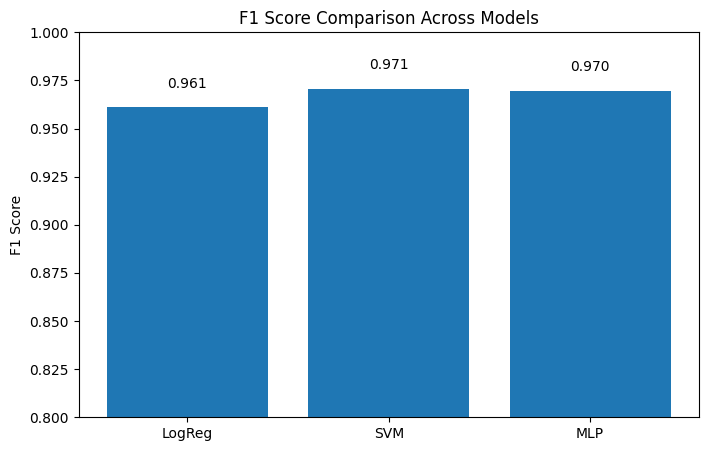

In [43]:
models = ["LogReg", "SVM", "MLP"]
f1s = [
    f1_score(y_test, y_pred_log),
    f1_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_best)
]

plt.figure(figsize=(8,5))
bars = plt.bar(models, f1s)
plt.title("F1 Score Comparison Across Models")
plt.ylabel("F1 Score")
plt.ylim(.8, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}", ha='center')

plt.show()

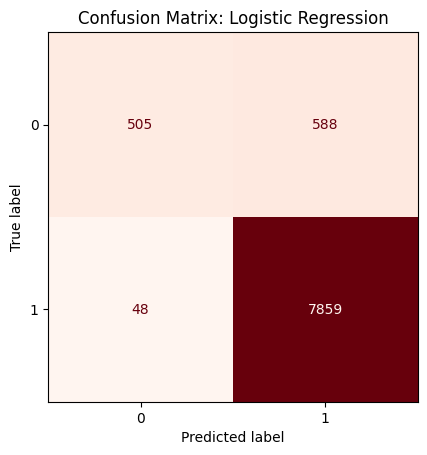

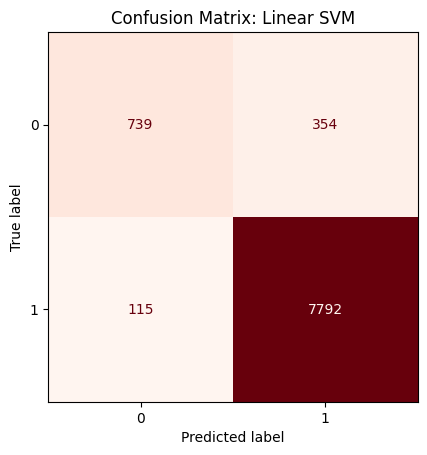

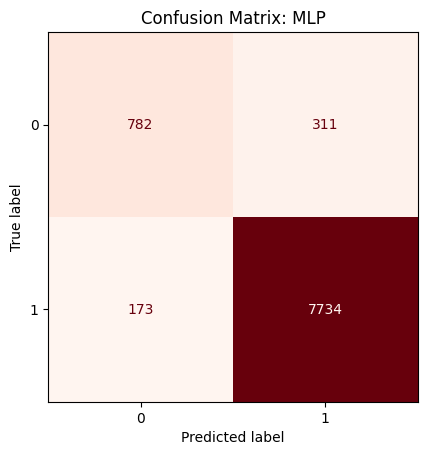

In [49]:
models = {
    "Logistic Regression": y_pred_log,
    "Linear SVM": y_pred_svm,
    "MLP": y_pred_best
}

for name, preds in models.items():
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, preds,
        cmap="Reds",
        colorbar=False
    )
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

All three model perform very well in our project with some key differences.

Logistic regression got a 92.9% accuracy score but was very bad at the 0 class, this means the model favors the majority side (1). This causes it to struggle to identify the negative data. And although the scores may look ok, I would argue that this is not a good model for this type of data

Linear SVM: This actually got our best score of 94.79 not by much though. It did perform better with the 0 and negative numbers than LR. We can say that svm's decision boundary is better suited for this type of data 

MLP (with hyper parameter tuning): This model also scored just about the same as svm with 94.73. But it did deliver the best performance with the (0) negative class. This is likely due to it being non linear and a neural network, was able to capture non linear relationships to improve its performance. If I had to choose one model that I would prefer for this project I think it would be this one. 

Conclusion:
A lot of things went well in my project, namely the TF-IDF vectorization help produce good data as well as my initial cleaning. All my models had very high precision scores and the EDA process was a big contributer to it. Also my hyperparameter tuning went well and showed for my mlp model that small networks that have a strong relgularization can outperform other architecture. This shows that tuning a model could provide benefit to outcomes

Some challenges that I had were that there was a big imbalance with the data, as reviews tended to be more positive than negative. This caused a lot of my models to have low recall and really showed the limitations of linear models when the data is this way. I also had some hardware limitations as I was working on a laptop that isn't so powerful, this made running more complex models difficult and I had to adjust my samples because of that. 

Things I want to improve for the future is that I would have been nice to do more techniques like weight balancing before hand to handle the imbalance of negative and positive reviews. It would also be nice to have a more powerful processor to run more intense neural networks on this data.



References:
Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

SVM
https://scikit-learn.org/stable/modules/svm.html

MLP
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
https://www.geeksforgeeks.org/multilayer-perceptron-mlp-explained/

Data provided by:
Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019
